# Jobs.ch - Web Scraping

The idea of this notebook is to scrape all the data available for some Data Science related jobs to analyze the existing overlaps between different roles afterwards.

Roles we are going to use:
* Data Scientist
* Data Analyst
* Data Engineer
* Machine Learning Engineer
* Big Data Analyst
* Data Architect

Location:
* Switzerland

Webpage:
* https://www.jobs.ch/en/

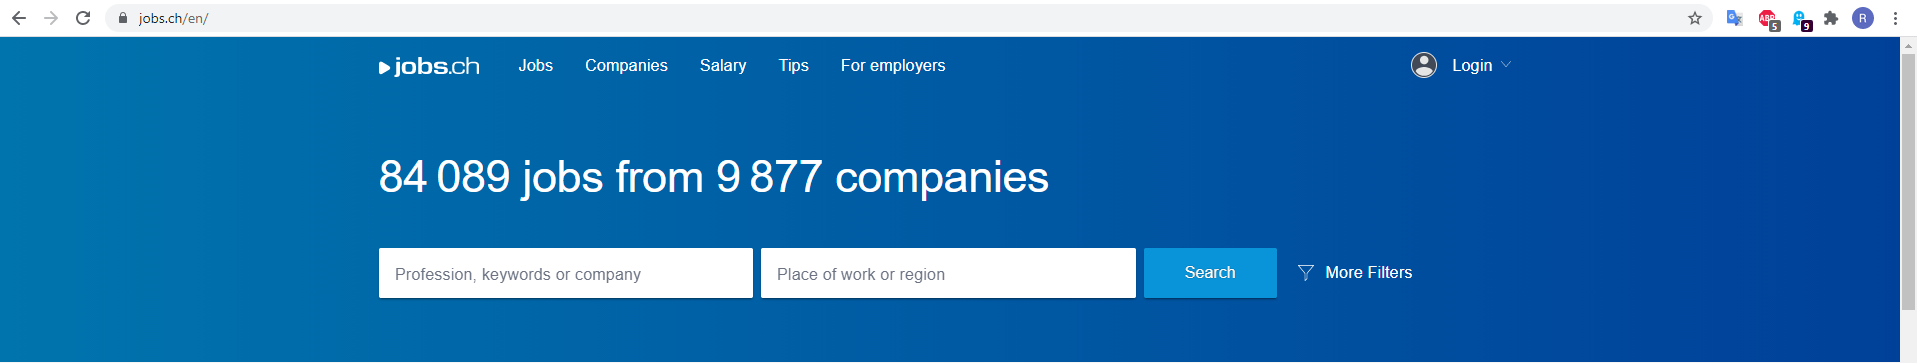

In [15]:
# Libraries required in alphabetic order
from bs4 import BeautifulSoup
from datetime import date
import pandas as pd
import requests
import time

The first thing we are going to do is define all the dynamic parameters that we are going to need in order to scrape the web page.

In [2]:
# Roles
jobs_list = ["Data Scientist",
             "Data Analyst",
             "Data Engineer",
             "Machine Learning Engineer",
             "Big Data Analyst",
             "Data Architect"]

# Location
location = "Switzerland"

# url configuration
url = "https://www.jobs.ch/en/vacancies/?"
url_location = "location="
url_term = "term="
url_job_id = "jobid="
page = "page="

The scraping process will have 3 main parts:

1. Scrape the first page of the search to get the total number of pages with jobs.

    https://www.jobs.ch/en/vacancies/?location=Switzerland&term=Data%20Analyst

2. Go trough each page and download the "job_id" for each job.

3. Open the details of each job with the job_id obtained in the previous step to scrape all the interesting data.

    https://www.jobs.ch/en/vacancies/?location=Switzerland&term=Data%20Analyst&jobid=00004773904ecc9e813a122516271e790b9afc2539

Let's start by creating the function to get the number of pages to scrape for each role.

In [3]:
# Function to get the num of pages with jobs given a role and location
def num_pages(job_title: str, location: str):
    """
    Scrapes the num of pages with jobs.
    
    Parameters:
        job_name: name of the job to be searched. (ex: Data Analyst)
        location: location of the jobs to search. (ex: Switzerland)
    
    Output:
        num_pages: returns the number of pages existing for one specific job and location.
    
    """
    # Encode the job_title
    job_search = job_title.replace(" ", "%20")

    # Create the url to call
    url_scrape = url + url_location + location + "&" + url_term + job_search

    # Send the "get" call
    try:
        page = requests.get(url_scrape, timeout=1)
        soup = BeautifulSoup(page.content, "html.parser")
    except:
        print("requests error")

    # Get the max number of pages to iterate over
    try:
        num_pages = soup.find("span", {"data-cy":"page-count"}).get_text()
        num_pages = int(num_pages.split("/")[1].strip())
    except:
        num_pages = 1
    
    return num_pages


def url_scrape(url):
    """
    
    Parameters:
        url: url to scrape.
    
    Output:
        status: get call status (OK/KO)
        job_link: list of all the html items that contain the job_id's 
    
    """
    try:
        resp = requests.get(url, timeout=1)
        soup = BeautifulSoup(resp.content, "html.parser")
        job_link = soup.findAll('a', {"data-cy":"job-link"})
        status = "OK"
    except:
        print("Timeout error")
        status = "KO"
        time.sleep(2)
    
    return status, job_link



In order to control the web scrapping process we will create a different dataframe to store the logs

In [4]:
# Create the dataframe to store the logs of the scraping process
column_names = ["step_num", "step_name", "start_time", "end_time", "duration_sec", "status"]
jobs_extr_logs_df = pd.DataFrame(columns=column_names)

# Define a function to insert the data in the logs dataframe
def insert_log(step, step_name, start_time, end_time, status):
    """
    This function will insert the records in the logs dataframe to keep track of the scraping process.
    
    Parameters:
        step:
        step_name:
        start_time:
        end_time:
        status:
    
    Output:
    

    """
    duration_sec = end_time - start_time
    
    append_dict = {"step_num": step,
                   "step_name": step_name,
                   "start_time": start_time,
                   "end_time": end_time,
                   "duration_sec": duration_sec,
                   "status": status
                  }

    jobs_extr_logs_df = jobs_extr_logs_df.append(append_dict, True)

jobs_extr_logs_df

,step_num,step_name,start_time,end_time,duration_sec,status


Once we have the function above defined, we will start to do the searches for each role and iterate over each page to obtain the id's of all the jobs.

In [6]:
# Create a dictionary with the pages for each job

# Dictionary that will contain the role and the id of the jobs to scrape.
jobs_dict = {}

# loop to get all the job_id's
for job_title in jobs_list:
    
    # Calculate the num of pages to iterate over
    start_time = time.time()
    max_page = num_pages(job_title, location)
    end_time = time.time()

    # Register the logs for this step
    # insert_log(step=1, step_name="Get page number", start_time=start_time, end_time=end_time, status="OK")
    
    job_title_url = job_title.replace(" ", "%20")
    
    # List that will contain all the job_id's
    jobs_codes = []
    
    for page_num in range(1, max_page + 1):        
        
        # Compose the url to call
        url_search = url + url_location + location + "&" + page + str(page_num) + "&" + url_term + job_title_url
        
        status, job_link = url_scrape(url_search)
        
        # Register the logs for this step
        # insert_log(step, step_name, start_time, end_time, status)
                        
        # If call error, repeat process some time
        
        # Get the job_id from the get response
        for element in job_link:
            job_code = element.get("href").split("/")[4]
            jobs_codes.append(job_code)
            jobs_codes = jobs_codes
            
    # Insert in the dictionary each role with a list of job_id's to scrape.
    jobs_dict[job_title] = jobs_codes

In [11]:
# For example for the role of "Data Scientist" we will have all the following job_id's to scrape:
jobs_dict["Data Scientist"]

['10600410',
 '00000571516cc6060110e67d3cd47f4a26cce980a9',
 '0000714304e80ebc8119849bf2ae9cf86d691260a5',
 '0000057796971436431aef6875a9b7997990809a5f',
 '000071430494c3b4e76797490ce08fd47e8ae94b37',
 '0000850872e15c027878769105245d70d62feb6ba8',
 '0000437865552fe8d144cb51cd275fae75a4affa0d',
 '00008508726e1a2e92e3890cefc5cfb28b33d205df',
 '0000057151050b139c52a5604eb65dd38276046e8c',
 '0000057151af703b7126914b1fc1ce6c65d607169a',
 '0000453836e511b33157569153140fd2def0e1e648',
 '000085087277e2d2af1eb9d9586c93693a09aa4a11',
 '0000059367108b7b333a9ab538b0411b86fabb10f4',
 '0000059367ff0c441076c6fbb8ffdca09569a1e58c',
 '00008508720e57373666e0591a681e147e96a9be44',
 '0000850872341e8f08a86af09c3042d5ec3d1bb4ae',
 '0000850872cf312d370350f18c58e3a112c2159e0f',
 '0000850872bfd008919ac72296892c69e0756674e6',
 '00004773904ecc9e813a122516271e790b9afc2539',
 '000085087225786f8683aa769a6221620fb100ce4f',
 '10600410',
 '0000850872b54266c4123fac55a7682e6441f8f605',
 '00008508724df30c58d63997cc96527f

In the following part of the notebook we are going to define different functions for each one of the fields that we want to get:

* Job description:
* Posted date:
* Company name:
* Location:
* Job name:

In [23]:
# Define the functions to extract the data from each job description.
def extr_job_desc(soup):
    try:
        job_desc = soup.find("div", {"class": "sc-dkPtyc DetailVacancyTextHtmlComponent___StyledDiv-sc-1b688f6-0 bUboxJ gskOiI"}).get_text()
    except:
        job_desc = None
    
    return job_desc


def extr_posted_date(soup):
    try:
        posted_date = soup.find("span", {"class": "sc-fotPbf Badge-sc-88vuku-0 khTXES dnDrau"}).get_text()
    except:
        posted_date = None
    
    return posted_date


def extr_company_name(soup):
    try:
        company_name = soup.find("span", {"class": "sc-fotPbf dUvvPk"}).get_text()
    except:
        try:
            company_name = soup.find("span", {"class": "sc-fotPbf Text__span-jiiyzm-8 Text-jiiyzm-9 jpFXVK eQChBQ"}).get_text()
        except:
            company_name = None
    
    return company_name


def extr_location(soup):
    try:
        location = soup.findAll("span", {"class": "sc-fotPbf Text__span-jiiyzm-8 Text-jiiyzm-9 jpFXVK eQChBQ"})[1].get("title")
    except:
        location = soup.find("span", {"class": "sc-fotPbf Text__span-jiiyzm-8 Text-jiiyzm-9 jpFXVK eQChBQ"}).get("title") 

    return location


def extr_job_name(soup):
    try:
        job_name = soup.find("div", {"class": "sc-dkPtyc Flex-sc-8fidy7-0 VacancyDetailHeadCompanyMedia___StyledFlex-sc-1fwdtwp-2 bbYFzC goUsBD"}).find("h2").get_text()
    except:
        job_name = None
    
    return job_name


Now that we have all the job_id's scrapped and the functions to get the data defined, we can start doing the search for each job and scrape all the data.

In [24]:
# Create the dataframe that will contain all the data for each job scrapped.
jobs_ch_df = pd.DataFrame()
job_id_get_error = []

pd.set_option('display.max_colwidth', None)

# Start of the scrapping process
for key, job_ids in jobs_dict.items():
    
    job_title = key.replace(" ", "%20")
    
    for job_id in job_ids:
 
        # url creation
        url_search = url + url_location + location + "&" + url_term + job_title + "&" + url_job_id + str(job_id)

        # Calling the server
        try:
            page = requests.get(url_search, timeout=2)
            soup = BeautifulSoup(page.content, "html.parser")
        except:
            print("Timeout error")
            job_id_get_error.append(job_id)
            time.sleep(1)

        # Extract data using the functions defined
        job_name = extr_job_name(soup)
        company_name = extr_company_name(soup)
        posted_date = extr_posted_date(soup)
        job_location = extr_location(soup)
        job_desc = extr_job_desc(soup)
        reference_date = date.today()

        # Append data to dataframe
        append_dict = {"job_id" : job_id,
                       "job_name" : job_name,
                       "company_name" : company_name,
                       "posted_date" : posted_date,
                       "location" : job_location,
                       "job_description" : job_desc,
                       "reference_date" : reference_date,
                       "job_search" : key
                      }

        jobs_ch_df = jobs_ch_df.append(append_dict, True)
    
    print("Step 3 (data_extraction): {} - OK".format(key))

Step 3 (data_extraction): Data Scientist - OK
Step 3 (data_extraction): Data Analyst - OK
Step 3 (data_extraction): Data Engineer - OK
Step 3 (data_extraction): Machine Learning Engineer - OK
Step 3 (data_extraction): Big Data Analyst - OK
Step 3 (data_extraction): Data Architect - OK


In [25]:
# Check the data frame
jobs_ch_df.head(3)

,job_id,job_name,company_name,posted_date,location,job_description,reference_date,job_search
0,10600410,High Content Screening and Automation Expert,Friedrich Miescher Institute for Biomedical Research,20 August,"Basel, Switzerland",None,2021-09-07,Data Scientist
1,00000571516cc6060110e67d3cd47f4a26cce980a9,Data Scientist / Visualization Business Analyst,wega Informatik AG,12 August,Switzerland,"Data Scientist / Visualization Business Analyst \n\n Click here to login or register \n\n\n\n\n\nSearch For more jobs | Forward this job to a friend | APPLY by email without registration | APPLY by creating / using an account \n\n\n\n\nReference # : \n20-00017 \nTitle : \nData Scientist / Visualization Business Analyst \n\n\nLocation : \n Switzerland \n\n\nPosition Type : \nContract/Temporär \n\n\nExperience Level : \n6 Years \nStart Date / End Date : \n01/02/2021 / 31/12/2020 \n \n\n\n Description \n\n\nGeneral information: Start date: ASAPEnd date: 31.12.2021 (an extension is possible)Work load: 80 - 100%Work location: Basel and remote Main tasks: \n \nAggregate and create simple but powerful data representations from distributed data sources \nPrioritize, often conflicting requirements in close collaboration with key business stakeholders \nCollaborate closely with the project delivery team to establish epics, user stories, acceptance criteria and detailed specifications \nContribute to development sprints by explaining and detailing requirements to the delivery team, and by reviewing and providing feedback on delivered solutions \nServe as the single point of contact between the business and the development team and translate business user stories into technical user stories \nServe as an interface to the testing team, to explain test objectives and ensure automation of test scripts wherever possible \n Qualification and Experience: \n \nUniversity degree in Biology, IT or similar background \nHands on experience in Data Visualization/Graphic Design discipline \nStrong analytical skills combined with conceptual thinking and structured working style \nAbility to work in a multicultural geographically distributed team \nStrong communication skills \nFluent in English \nKnowledge of data visualisation tools, such as D3.js, Plotly and project-based work experience in the pharmaceutical industry would be a big plus \n \n\n\n\n",2021-09-07,Data Scientist
2,0000714304e80ebc8119849bf2ae9cf86d691260a5,Clinical Research Scientist - contractor Switzerland,Consultants in Science Sàrl,08 February,Suisse Switzerland,"Clinical Research Scientist - contractor Switzerland \n \n \nFeb 8 \n1 min read \n \n Clinical Research Scientist - contractor Switzerland We are looking for a Clinical Research Scientist for a contract with a global pharmaceutical company in the Neuchatel area, Switzerland. Home-based working is possible but the position holder must be resident in Switzerland or willing to relocate to Switzerland. Key requirements for this position include: \n Experience in clinical research and development in clinical science capacity. \n Experience in performing clinical data review review. \n Familiar with working with data listings and laboratory data. \n Previous experience in clinical research in hematology/oncology field \n Ability to function independently. \n Please contact recruitment@consultantsinscience.com for more information \nVacancies \n We are looking for a Clinical Research Scientist for a contract with a global pharmaceutical company in the Neuchatel area, Switzerland. Home-based working is possible but the position holder must be resident in Switzerland or willing to relocate to Switzerland. Key requirements for this position include: \n Experience in clinical research and development in clinical science capacity. \n Experience in performing clinical data review review. \n Familiar with working with data listings and laboratory data. \n Previous experience in clinical research in hematology/oncology field \n Ability to function

In [30]:
# Check nulls for each column (%)
round(jobs_ch_df.isnull().sum() / len(jobs_ch_df) * 100)

job_id             0.0
job_name           0.0
company_name       0.0
posted_date        0.0
location           0.0
job_description    5.0
reference_date     0.0
job_search         0.0
dtype: float64

In [31]:
# Write to csv
jobs_ch_df.to_csv("data_jobs_switzerland.csv", index=False)